In [1]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import pandas as pd
import time

def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Start timer
        result = func(*args, **kwargs)
        end_time = time.time()  # End timer
        print(f"{func.__name__} executed in {end_time - start_time:.6f} seconds")
        return result
    return wrapper

In [2]:
# Define the place name or coordinates
place_name = "Kathmandu, Nepal"  

# Download the street network
G = ox.graph_from_place(place_name, network_type='drive')  # 'all' includes all types of roads
G = ox.project_graph(G, to_crs="EPSG:3857")  # Web Mercator

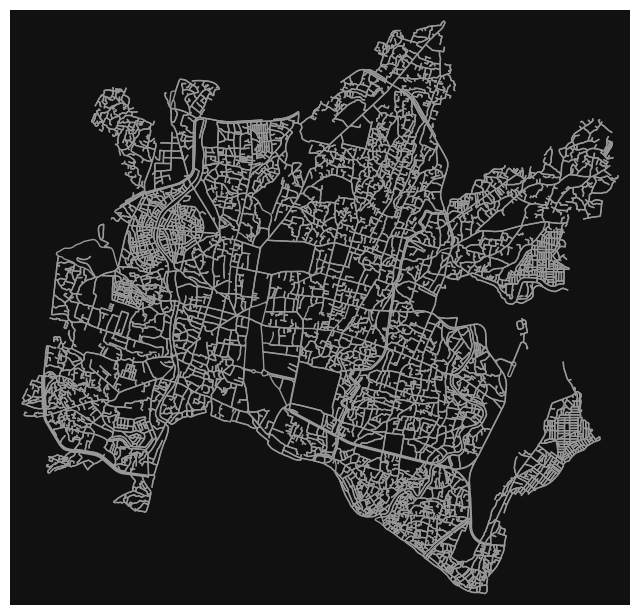

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [59]:
ox.plot_graph(G,node_size=0)

In [10]:
pd.set_option('display.max_columns', None)
nodes, edges = ox.graph_to_gdfs(G)

In [ ]:
print(edges['geometry'].values)
print(edges['length'])

In [11]:
def create_adjacency_list(gdf):
    adjacency_list = {}
    gdf = gdf.reset_index()
    for _, row in gdf.iterrows():
        u, v, weight = row['u'], row['v'], row['length']

        # Add edge u -> v
        if u not in adjacency_list:
            adjacency_list[u] = []
        one_way = gdf[(gdf["u"] == u) & (gdf["v"] == v)]
        if not one_way.empty and not one_way.iloc[0]['oneway']:            
            adjacency_list[u].append((v, weight))
        
        if v not in adjacency_list:
            adjacency_list[v] = []

        one_way = gdf[(gdf["u"] == v) & (gdf["v"] == u)]
        if not one_way.empty and not one_way.iloc[0]['oneway']:            
            adjacency_list[v].append((u, weight))

    return adjacency_list

In [12]:
adj_list = create_adjacency_list(edges)

In [51]:
import heapq

@timing_decorator
def dijkstra(adj_list, start, target):
    """Custom Dijkstra’s Algorithm to find the shortest path"""
    pq = [(0, start)]  # Min-heap: (distance, node)
    shortest_paths = {node: float('inf') for node in adj_list}
    shortest_paths[start] = 0
    predecessors = {}  # To reconstruct the path

    while pq:
        current_cost, current_node = heapq.heappop(pq)

        # Stop early if we reach the target node
        if current_node == target:
            break

        for neighbor, weight in adj_list.get(current_node, []):
            distance = current_cost + weight

            if distance < shortest_paths[neighbor]:
                shortest_paths[neighbor] = distance
                predecessors[neighbor] = current_node
                heapq.heappush(pq, (distance, neighbor))

    # Reconstruct the shortest path
    path = []
    node = target
    while node in predecessors:
        path.append(node)
        node = predecessors[node]
    path.append(start)
    path.reverse()

    return path, shortest_paths[target] if shortest_paths[target] != float('inf') else None

In [14]:
orig = list(G.nodes())[0]
dest = list(G.nodes())[100]

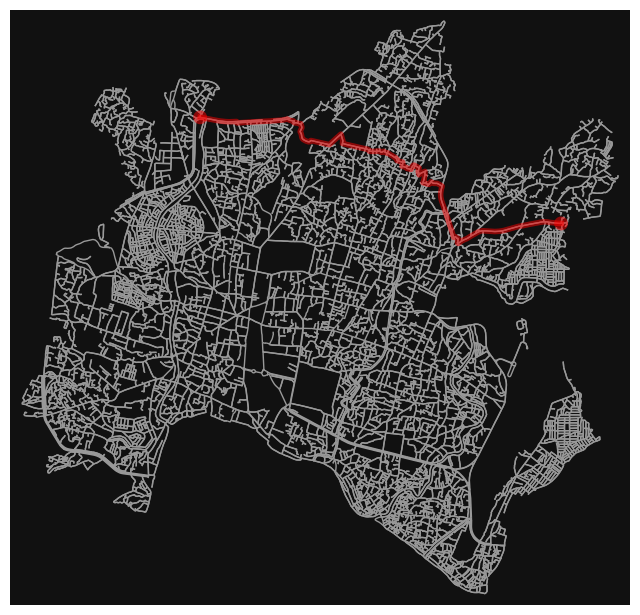

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [15]:
route_dj_1 = dijkstra(adj_list,orig,dest)
ox.plot_graph_route(G,route=route_dj_1[0],node_size=0)

In [50]:
import heapq
import math

def euclidean_heuristic(node1, node2):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

@timing_decorator
def a_star(graph, start, goal, heuristic):
    pq = [(0, start)]  # (f(n), node)
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0
    predecessors = {}  

    while pq:
        _, current = heapq.heappop(pq)

        if current == goal:
            break  # Path found

        for neighbor, weight in graph[current]:
            temp_g = g_score[current] + weight
            if temp_g < g_score[neighbor]:
                g_score[neighbor] = temp_g
                f_score = temp_g + heuristic(neighbor, goal)
                heapq.heappush(pq, (f_score, neighbor))
                predecessors[neighbor] = current

    # Reconstruct path
    path = []
    node = goal
    while node in predecessors:
        path.append(node)
        node = predecessors[node]
    path.append(start)
    path.reverse()
    
    return path, g_score[goal] if g_score[goal] != float('inf') else None


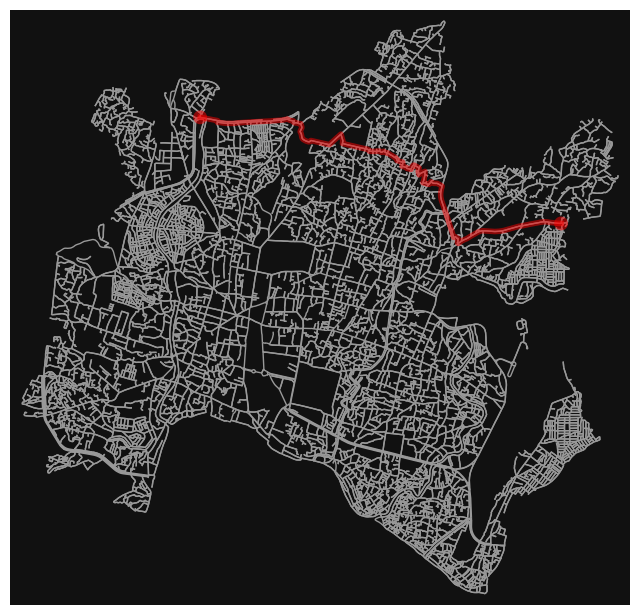

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
route_a_star_1 = a_star(adj_list,orig,dest,euclidean_heuristic)
ox.plot_graph_route(G,route=route_a_star_1[0],node_size=0)

In [48]:
@timing_decorator
def multi_stop_dijkstra(adj_list,start,target,stops):
    if not stops:
        print("No stop found")
        return dijkstra(adj_list,start,target)
    total_nodes = []
    route = dijkstra(adj_list,start,stops[0])
    total_nodes.extend(route[0])
    for i in range(len(stops)-1):
        print("Calculating stop nodes")
        route = dijkstra(adj_list,stops[i],stops[i+1])
        total_nodes.extend(route[0][1:])
    route = dijkstra(adj_list,stops[-1],target)
    total_nodes.extend(route[0][1:])
    return total_nodes

In [49]:
@timing_decorator
def multi_stop_a_star(adj_list,start,target,stops,heuristic):
    if not stops:
        print("No stop found")
        return a_star(adj_list,start,target,heuristic)
    total_nodes = []
    route = a_star(adj_list,start,stops[0],heuristic)
    total_nodes.extend(route[0])
    for i in range(len(stops)-1):
        print("Calculating stop nodes")
        route = a_star(adj_list,stops[i],stops[i+1],heuristic)
        total_nodes.extend(route[0][1:])
    route = a_star(adj_list,stops[-1],target,heuristic)
    total_nodes.extend(route[0][1:])
    return total_nodes

In [44]:
def find_nearest_osm_node(place_name):
    # Get latitude and longitude of the place
    location = ox.geocode(place_name)
    
    # Load the OSM graph for the area
    G = ox.graph_from_point(location, dist=1000, network_type="drive")  # 1km radius
    
    # Find the nearest node
    nearest_node = ox.distance.nearest_nodes(G, X=location[1], Y=location[0])
    
    return nearest_node

In [45]:
orig = find_nearest_osm_node("Lazimpat")
dest = find_nearest_osm_node("Kathmandu")
stop1 = find_nearest_osm_node("Samakhusi")
stop2 = find_nearest_osm_node("Chakrapath")
stop3 = find_nearest_osm_node("Kalanki")

a_star executed in 0.002998 seconds
Calculating stop nodes
a_star executed in 0.002375 seconds
Calculating stop nodes
a_star executed in 0.007484 seconds
a_star executed in 0.009034 seconds
multi_stop_a_star executed in 0.021892 seconds


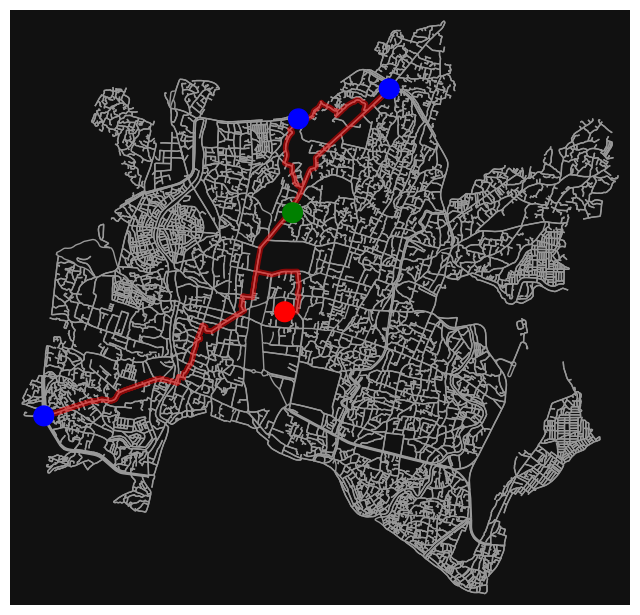

In [64]:
stop_nodes = [stop1,stop2,stop3]
route_a_star_2 = multi_stop_a_star(adj_list,orig,dest,stop_nodes,euclidean_heuristic)
fig,ax = ox.plot_graph_route(G,route=route_a_star_2,node_size=0,show=False, close=False)
# Highlight start, stops, and target
nodes_to_highlight = [orig] + stop_nodes + [dest]
node_colors = ["green"] + ["blue"] * len(stop_nodes) + ["red"]  # Green for start, blue for stops, red for target

# Get node coordinates
node_xs = [G.nodes[node]["x"] for node in nodes_to_highlight]
node_ys = [G.nodes[node]["y"] for node in nodes_to_highlight]

ax.scatter(node_xs, node_ys, c=node_colors, s=200, zorder=3)

plt.show()

dijkstra executed in 0.005355 seconds
Calculating stop nodes
dijkstra executed in 0.003373 seconds
Calculating stop nodes
dijkstra executed in 0.023263 seconds
dijkstra executed in 0.011869 seconds
multi_stop_dijkstra executed in 0.044940 seconds


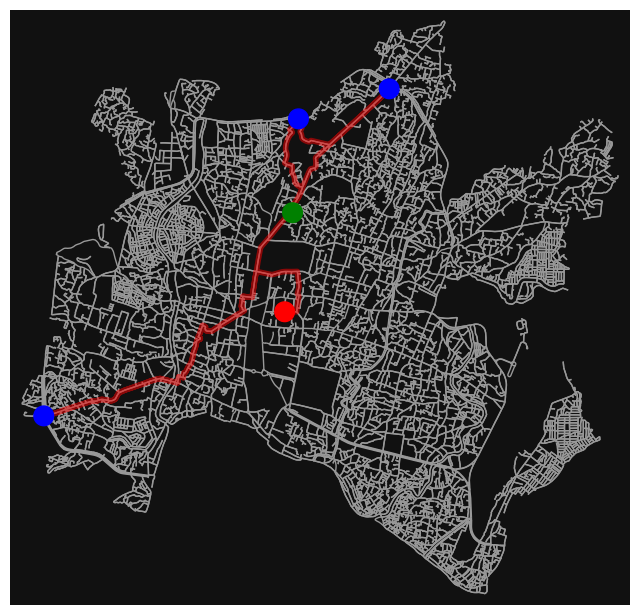

In [63]:
stop_nodes = [stop1,stop2,stop3]
route_dj_3 = multi_stop_dijkstra(adj_list,orig,dest,stop_nodes)
fig,ax = ox.plot_graph_route(G,route=route_dj_3,node_size=0,show=False, close=False)
# Highlight start, stops, and target
nodes_to_highlight = [orig] + stop_nodes + [dest]
node_colors = ["green"] + ["blue"] * len(stop_nodes) + ["red"]  # Green for start, blue for stops, red for target

# Get node coordinates
node_xs = [G.nodes[node]["x"] for node in nodes_to_highlight]
node_ys = [G.nodes[node]["y"] for node in nodes_to_highlight]

ax.scatter(node_xs, node_ys, c=node_colors, s=200, zorder=3)

plt.show()

Calculating stop nodes
Calculating stop nodes
Calculating stop nodes
Calculating stop nodes


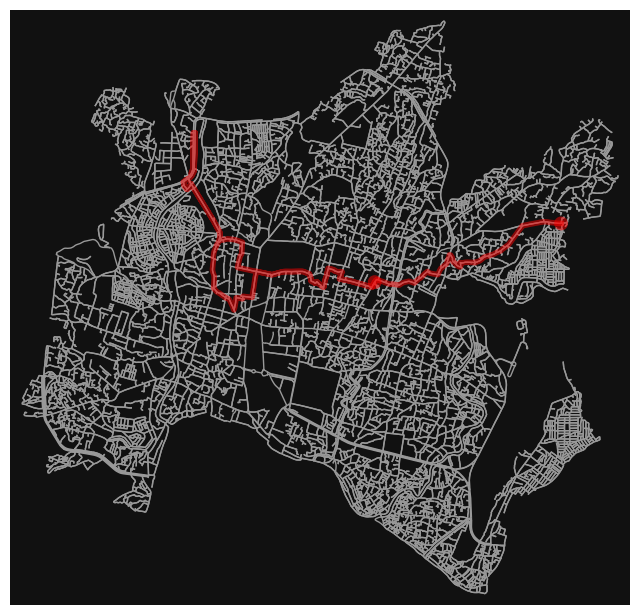

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [38]:
orig = list(G.nodes())[0]
dest = list(G.nodes())[100]

stop1 = list(G.nodes())[350]
stop2 = list(G.nodes())[150]
stop3 = list(G.nodes())[250]
stop4 = list(G.nodes())[300]
stop5 = list(G.nodes())[20]
route_dj_2 = multi_stop_dijkstra(adj_list,orig,dest,[stop1,stop2,stop3,stop4,stop5])
ox.plot_graph_route(G,route=route_dj_2,node_size=0)